In [4]:
import torch
from train import netG, my_transforms, unnormalize_functional, mean, std, device, to_rgb
from models import unnormalize_to
from PIL import Image
import torchvision.transforms.functional as TF
from IPython.display import SVG, display
import svgwrite
from cairosvg import svg2png
from pathlib import Path
from tqdm.notebook import tqdm

In [5]:
netG.load_state_dict(torch.load(r".\checkpoints\2021-11-15-19.08.27\210000__1.4482669830322266.pt")['G'])
netG.to(device)
netG.eval()
pass

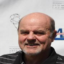

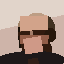

In [6]:
input_image = Image.open(r"C:\projects\data\celeba_val\main\008189.jpg")
input_tensor = my_transforms(input_image).to(device)
display(TF.to_pil_image(unnormalize_functional(input_tensor, mean, std)))
netG.return_mode = "bitmap"
output_image = to_rgb(netG(input_tensor.unsqueeze(0)).squeeze(0))
display(TF.to_pil_image(unnormalize_functional(output_image, mean, std)))

netG.return_mode = "shapes"
output_image_args = netG(input_tensor.unsqueeze(0)).squeeze(0).detach().cpu()

In [49]:
def save_svg(shapes_args, filename, canvas_height=500, canvas_width=500):
    dwg = svgwrite.Drawing(filename, profile='tiny', size=(canvas_width, canvas_height))
    r, g, b = 255*(mean.cpu() + std.cpu())
    bgr_color = svgwrite.rgb(r, g, b)
    dwg.add(dwg.rect(insert=(0, 0), size=(canvas_width, canvas_height), fill=bgr_color))

    mr, mg, mb = mean
    sr, sg, sb = std

    for shape_args in shapes_args:
        _, _, pos_x, pos_y, width, height, angle, squareness, r, g, b = shape_args
        pos_x = float(pos_x*canvas_height)
        pos_y = float(pos_y*canvas_width)
        height = float(height*canvas_height)
        width = float(width*canvas_width)
        width, height = height, width
        pos_x, pos_y = pos_y, pos_x
        angle = 180*float(angle)
        rgb = unnormalize_to(torch.stack([r, g, b]), -1.5, 1.5).view(-1, 1, 1)
        r, g, b = 255*unnormalize_functional(rgb, mean.cpu(), std.cpu()).view(-1)
        fill = svgwrite.rgb(r, g, b)
        if squareness > 0.5:
            shape = dwg.rect(insert=(pos_x-width, pos_y-height), size=(2*width, 2*height), fill=fill)
        else:
            shape = dwg.ellipse(center=(pos_x, pos_y), r=(width, height), fill=fill)
        shape.rotate(angle=angle, center=(pos_x, pos_y))
        dwg.add(shape)
    dwg.save()

    display(SVG(filename="./out.svg"))

In [10]:
input_path = Path(r"C:\projects\data\celeba/img_align_celeba/")
output_path = Path("./highres_outputs/") / (input_path.parent.name + "_pred")
output_path.mkdir(exist_ok=True, parents=True)

files = list(input_path.iterdir())

netG.return_mode = "shapes"

for file in tqdm(files):
    png_path = output_path / (file.stem + ".png")
    if png_path.exists():
        continue
    svg_path = output_path / (file.stem + ".svg")
    input_image = Image.open(file)
    input_tensor = my_transforms(input_image).to(device)
    output_image_args = netG(input_tensor.unsqueeze(0)).squeeze(0).detach().cpu()
    save_svg(output_image_args, svg_path, canvas_height=1080, canvas_width=1080)
    with open(svg_path, mode="rb") as svg_file:
        svg2png(bytestring=svg_file.read(), write_to=str(png_path))
    svg_path.unlink()

  0%|          | 0/202599 [00:00<?, ?it/s]

In [7]:
output_image_args.shape

torch.Size([16, 11])